# DuckDB + Parquet Data Exploration Template

In [1]:
import duckdb
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from branca.colormap import linear
from pathlib import Path
from shapely.geometry import box
import cartopy.io.shapereader as shpreader
from tqdm import tqdm

from src.util import make_cell_geom, create_config

# --- Configuration ---

In [2]:
BASE = Path("/Users/kyledorman/data/planet_coverage/points_30km/")  # <-- update this
config_file = BASE / "dove" / "results" / "2024" / "config.yaml"  # <-- update this
config = create_config(config_file)

# Example path patterns
all_files_pattern = str(BASE / "*/results/*/*/*/*/data.parquet")
all_parquets = list(BASE.glob("*/results/*/*/*/*/data.parquet"))

len(all_parquets)

17122

In [3]:
# 1. Use Cartopy's Natural Earth admin_1_states_provinces shapefile
shp_path = shpreader.natural_earth(resolution='10m',
                                   category='cultural',
                                   name='admin_1_states_provinces')
states = gpd.read_file(shp_path)

# 2. Filter to California
ca = states[(states['admin'] == 'United States of America') &
            (states['name'] == 'California')]

# 3. Project to CA Albers for buffering
ca_proj = ca.to_crs("EPSG:3310")

# 4. Buffer by 20 km
buffered = ca_proj.buffer(5e4)

# 6. Convert to GeoSeries and back to WGS84
square_wgs = gpd.GeoSeries([buffered.geometry.iloc[0]], crs="EPSG:3310").to_crs("EPSG:4326")

/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


In [4]:
orig_geo_df = gpd.read_file(config.grid_path)
gdf = orig_geo_df.to_crs(epsg=4326)

degree_size = config.degree_size
gdf["lon_bin"] = (np.floor(gdf.geometry.x / degree_size) * degree_size).astype(float)
gdf["lat_bin"] = (np.floor(gdf.geometry.y / degree_size) * degree_size).astype(float)
gdf["grid_index"] = gdf.index

# ----------------------------------------------------------------------------
# 1) group by cell and collect both points AND their original indices
# ----------------------------------------------------------------------------
grouped = (
    gdf.groupby(["lon_bin", "lat_bin"])
    .agg(
        {
            "geometry": list,  # list of Point geometries
            "grid_index": list,  # list of original indices
        }
    )
    .reset_index()
)
grouped["cell_geom"] = grouped["geometry"].apply(make_cell_geom)  # type: ignore
cells = gpd.GeoDataFrame(grouped, geometry="cell_geom", crs="EPSG:4326")

In [5]:
# Create the base map centered on the calculated location
centroid = square_wgs.geometry[0].centroid
base_map = folium.Map(location=[centroid.y, centroid.x], zoom_start=5, width=1000, height=800)

for idx, geo in enumerate(square_wgs):
    folium.GeoJson(
        geo,
        name=str(idx),
    ).add_to(base_map)

# Add each GeoJSON file to the map
# Add polygons to the map
intersects = gdf.geometry.intersects(square_wgs.geometry.iloc[0])
for idx, row in gdf[intersects].iterrows():
    pt = row["geometry"]
    folium.CircleMarker(
        location=[pt.y, pt.x],
        radius=0.5,
        color="red",
        fill=True,
        fill_opacity=0.1,
        popup=str(idx),
    ).add_to(base_map)

# Display the map
base_map

In [6]:
# --- Connect to DuckDB ---
con = duckdb.connect()

In [7]:
search_idx = gdf[gdf.geometry.intersects(square_wgs.geometry.iloc[0])].index[0]

for file in all_parquets:
    result = con.execute(
        f"SELECT COUNT(*) FROM read_parquet('{file}') WHERE grid_idx = {search_idx}"
    ).fetchone()[0]

    if result > 0:
        print(f"Found grid_idx {search_idx} in: {file}")
        single_file = file
        break

Found grid_idx 523398 in: /Users/kyledorman/data/planet_coverage/points_30km/dove/results/2024/00/03/51/data.parquet


In [8]:
# Register a view for all files
con.execute(f"""
    CREATE OR REPLACE VIEW samples_all AS
    SELECT * FROM '{all_files_pattern}'
""")

In [9]:
# Register a view for a single file for faster iteration
con.execute(f"""
    CREATE OR REPLACE VIEW samples_one AS
    SELECT * FROM '{single_file}'
""")

In [10]:
# --- Schema Inspection ---
print("Schema of samples_one:")
print(con.execute("DESCRIBE samples_one").fetchdf())

Schema of samples_one:
          column_name column_type null   key default extra
0       has_8_channel     BOOLEAN  YES  None    None  None
1                  id     VARCHAR  YES  None    None  None
2            acquired   TIMESTAMP  YES  None    None  None
3       clear_percent       FLOAT  YES  None    None  None
4           item_type     VARCHAR  YES  None    None  None
5    quality_category     VARCHAR  YES  None    None  None
6   satellite_azimuth       FLOAT  YES  None    None  None
7        satellite_id     VARCHAR  YES  None    None  None
8         sun_azimuth       FLOAT  YES  None    None  None
9       sun_elevation       FLOAT  YES  None    None  None
10         view_angle       FLOAT  YES  None    None  None
11         instrument     VARCHAR  YES  None    None  None
12           grid_idx    UINTEGER  YES  None    None  None


In [11]:
# --- NULL Check ---
print("Checking for NULL values:")
df_nulls = con.execute("""
    SELECT
        SUM(CASE WHEN has_8_channel IS NULL THEN 1 ELSE 0 END) AS null_has_8_channel,
        SUM(CASE WHEN id IS NULL THEN 1 ELSE 0 END) AS null_id,
        SUM(CASE WHEN acquired IS NULL THEN 1 ELSE 0 END) AS null_acquired,
        SUM(CASE WHEN clear_percent IS NULL THEN 1 ELSE 0 END) AS null_clear_percent,
        SUM(CASE WHEN item_type IS NULL THEN 1 ELSE 0 END) AS null_item_type,
        SUM(CASE WHEN quality_category IS NULL THEN 1 ELSE 0 END) AS null_quality_category,
        SUM(CASE WHEN satellite_azimuth IS NULL THEN 1 ELSE 0 END) AS null_satellite_azimuth,
        SUM(CASE WHEN sun_azimuth IS NULL THEN 1 ELSE 0 END) AS null_sun_azimuth,
        SUM(CASE WHEN sun_elevation IS NULL THEN 1 ELSE 0 END) AS null_sun_elevation,
        SUM(CASE WHEN view_angle IS NULL THEN 1 ELSE 0 END) AS null_view_angle,
        SUM(CASE WHEN instrument IS NULL THEN 1 ELSE 0 END) AS null_instrument,
        SUM(CASE WHEN grid_idx IS NULL THEN 1 ELSE 0 END) AS null_grid_idx
    FROM samples_one
""").fetchdf()
print(df_nulls)

Checking for NULL values:
   null_has_8_channel  null_id  null_acquired  null_clear_percent  \
0                 0.0      0.0            0.0                 0.0   

   null_item_type  null_quality_category  null_satellite_azimuth  \
0             0.0                    0.0                     0.0   

   null_sun_azimuth  null_sun_elevation  null_view_angle  null_instrument  \
0               0.0                 0.0              0.0              0.0   

   null_grid_idx  
0            0.0  


In [12]:
con.execute("SELECT DISTINCT item_type from samples_all").fetchdf()

item_type
0   PSScene

In [15]:
con.execute("SELECT DISTINCT quality_category from samples_all").fetchdf()

quality_category
0         standard
1             test

In [17]:
con.execute("SELECT DISTINCT instrument from samples_all").fetchdf()

instrument
0     PSB.SD

In [18]:
# --- Preview Data ---
df_preview = con.execute("SELECT * FROM samples_one LIMIT 10").fetchdf()
display(df_preview)

has_8_channel                       id                   acquired  \
0           True  20250427_184926_91_251b 2025-04-27 18:49:26.918164   
1           True  20250427_184926_91_251b 2025-04-27 18:49:26.918164   
2           True  20250427_184926_91_251b 2025-04-27 18:49:26.918164   
3           True  20250427_184926_91_251b 2025-04-27 18:49:26.918164   
4           True  20250427_184926_91_251b 2025-04-27 18:49:26.918164   
5           True  20250427_184926_91_251b 2025-04-27 18:49:26.918164   
6           True  20250427_184924_67_251b 2025-04-27 18:49:24.673044   
7           True  20250427_184924_67_251b 2025-04-27 18:49:24.673044   
8           True  20250427_185118_84_24db 2025-04-27 18:51:18.843979   
9           True  20250427_185118_84_24db 2025-04-27 18:51:18.843979   

   clear_percent item_type quality_category  satellite_azimuth satellite_id  \
0           55.0   PSScene             test         267.600006         251b   
1           55.0   PSScene             test         267.600006         251b   
2           55.0   PSScene             test         267.600006         251b   
3           55.0   PSScene             test         267.600006         251b   
4           55.0   PSScene             test         267.600006         251b   
5           55.0   PSScene             test         267.600006         251b   
6           37.0   PSScene             test         268.100006         251b   
7           37.0   PSScene             test         268.100006         251b   
8           97.0   PSScene             test         276.200012         24db   
9           97.0   PSScene             test         276.200012         24db   

   sun_azimuth  sun_elevation  view_angle instrument  grid_idx  
0   141.800003      67.599998         1.0     PSB.SD    524931  
1   141.800003      67.599998         1.0     PSB.SD    525176  
2   141.800003      67.599998         1.0     PSB.SD    525175  
3   141.800003      67.599998         1.0     PSB.SD    525428  
4   141.800003      67.599998         1.0     PSB.SD    525427  
5   141.800003      67.599998         1.0     PSB.SD    525689  
6   142.000000      67.500000         1.0     PSB.SD    525689  
7   142.000000      67.500000         1.0     PSB.SD    525955  
8   141.500000      67.599998         2.6     PSB.SD    524470  
9   141.500000      67.599998         2.6     PSB.SD    524471

In [19]:
# --- Count Rows ---
print("Total rows in sample file:")
print(con.execute("SELECT COUNT(*) FROM samples_one").fetchone()[0])


Total rows in sample file:
12593


In [20]:
# --- Filter By Time ---
df_2024 = con.execute("""
    SELECT *
    FROM samples_one
    WHERE acquired >= '2024-01-01' AND acquired < '2025-01-01'
    LIMIT 100
""").fetchdf()
display(df_2024)

has_8_channel                       id                   acquired  \
0            True  20241231_180323_00_24ca 2024-12-31 18:03:23.007778   
1            True  20241231_180323_00_24ca 2024-12-31 18:03:23.007778   
2            True  20241231_180323_00_24ca 2024-12-31 18:03:23.007778   
3            True  20241231_180323_00_24ca 2024-12-31 18:03:23.007778   
4            True  20241231_180323_00_24ca 2024-12-31 18:03:23.007778   
..            ...                      ...                        ...   
95           True  20241230_184806_74_2512 2024-12-30 18:48:06.749095   
96           True  20241230_184806_74_2512 2024-12-30 18:48:06.749095   
97           True  20241230_184806_74_2512 2024-12-30 18:48:06.749095   
98           True  20241230_184806_74_2512 2024-12-30 18:48:06.749095   
99           True  20241230_184806_74_2512 2024-12-30 18:48:06.749095   

    clear_percent item_type quality_category  satellite_azimuth satellite_id  \
0             2.0   PSScene             test         108.599998         24ca   
1             2.0   PSScene             test         108.599998         24ca   
2             2.0   PSScene             test         108.599998         24ca   
3             2.0   PSScene             test         108.599998         24ca   
4             2.0   PSScene             test         108.599998         24ca   
..            ...       ...              ...                ...          ...   
95           39.0   PSScene         standard         277.200012         2512   
96           39.0   PSScene         standard         277.200012         2512   
97           39.0   PSScene         standard         277.200012         2512   
98           39.0   PSScene         standard         277.200012         2512   
99           39.0   PSScene         standard         277.200012         2512   

    sun_azimuth  sun_elevation  view_angle instrument  grid_idx  
0    151.500000      29.100000         0.8     PSB.SD    523804  
1    151.500000      29.100000         0.8     PSB.SD    523803  
2    151.500000      29.100000         0.8     PSB.SD    524020  
3    151.500000      29.100000         0.8     PSB.SD    524019  
4    151.500000      29.100000         0.8     PSB.SD    524240  
..          ...            ...         ...        ...       ...  
95   162.300003      32.200001         5.0     PSB.SD    525955  
96   162.300003      32.200001         5.0     PSB.SD    525954  
97   162.300003      32.200001         5.0     PSB.SD    526212  
98   162.300003      32.200001         5.0     PSB.SD    525426  
99   162.300003      32.200001         5.0     PSB.SD    525425  

[100 rows x 13 columns]

In [21]:
# Determine which cell this file corresponds to by matching its grid_idx
file_grid_idxs = con.execute("SELECT DISTINCT grid_idx FROM samples_one").fetchdf()["grid_idx"].tolist()
cells_containing_file_data = cells[cells["grid_index"].apply(lambda lst: any(idx in file_grid_idxs for idx in lst))]

# Flatten all grid indices in the matched cell
matching_indices = set(idx for lst in cells_containing_file_data["grid_index"] for idx in lst)
geo_filtered = gdf[gdf["grid_index"].isin(matching_indices)]

In [22]:
# --- Load Geo Points and Join ---

# Sample count per grid cell
df_counts = con.execute("""
    SELECT grid_idx, COUNT(*) as sample_count
    FROM samples_one
    GROUP BY grid_idx
""").fetchdf()

geo_plot = geo_filtered.join(df_counts.set_index("grid_idx"), how="left").fillna({"sample_count": 0})

# --- Create Folium Map of Sample Count ---
if geo_plot.sample_count.max() == geo_plot.sample_count.min():
    scale_min = 0
else:
    scale_min = geo_plot.sample_count.min()
color_scale = linear.viridis.scale(scale_min, geo_plot.sample_count.max())
m = folium.Map(
    location=[geo_plot.geometry.y.mean(), geo_plot.geometry.x.mean()], 
    zoom_start=8, 
    tiles="CartoDB positron",
    width=500, 
    height=500
)

for _, row in geo_plot.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        fill=True,
        fill_opacity=0.7,
        color=None,
        fill_color=color_scale(row.sample_count),
        popup=f"Grid ID: {row.name}<br>Samples: {row.sample_count}"
    ).add_to(m)

color_scale.caption = "Sample Count"
color_scale.width = 300  # Wider legend
color_scale.heght = 100  # Wider legend
color_scale.add_to(m)

m

<Axes: >

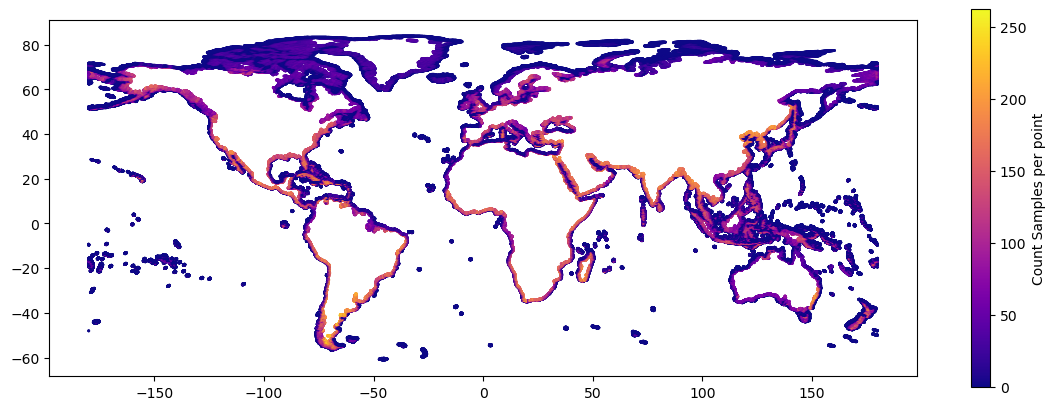

In [29]:
# --- Load Geo Points and Join ---

# Sample count per grid cell
df_counts_all = con.execute("""
    SELECT grid_idx, COUNT(*) as sample_count
    FROM samples_all
    GROUP BY grid_idx
""").fetchdf()

geo_plot = gdf.join(df_counts_all.set_index("grid_idx"), how="left").fillna({"sample_count": 0})

# Set up the figure
fig, ax = plt.subplots(figsize=(14, 7))

# Optional: Plot world basemap
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world.plot(ax=ax, color='lightgray', edgecolor='white')

# Plot points 
geo_plot.plot(
    ax=ax,
    column="sample_count",
    cmap="plasma",
    markersize=1,
    legend=True,
    legend_kwds={
        "label": "Count Samples per point",
        "shrink": 0.7,
        "orientation": "vertical"
    }
)

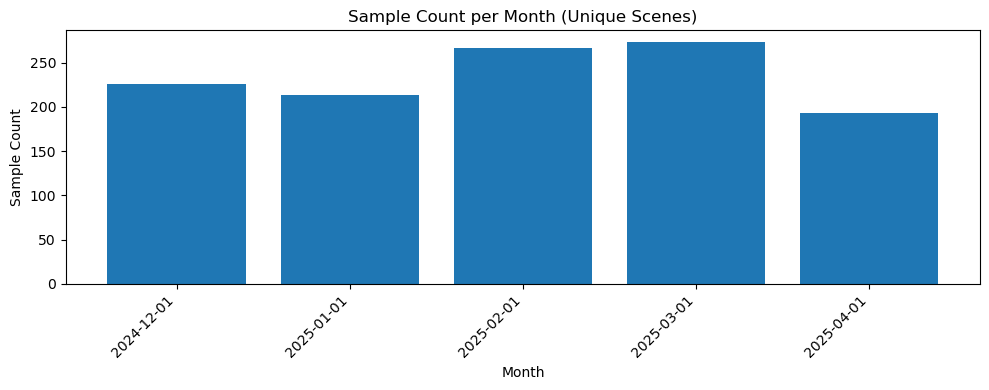

In [23]:
# --- Histogram of Sample Count per Month ---
df_monthly = con.execute("""
    SELECT date_trunc('month', acquired) AS month, COUNT(DISTINCT id) AS sample_count
    FROM samples_one
    WHERE item_type = 'PSScene'
    GROUP BY month
    ORDER BY month
""").fetchdf()

# Plot histogram
plt.figure(figsize=(10,4))
plt.bar(df_monthly['month'].astype(str), df_monthly['sample_count'])
plt.xticks(rotation=45, ha='right')
plt.title("Sample Count per Month (Unique Scenes)")
plt.xlabel("Month")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

In [24]:
# --- Fraction of has_8_channel per Grid Point ---
df_fraction_8ch = con.execute("""
    SELECT grid_idx,
           COUNT(*) AS total,
           SUM(CASE WHEN has_8_channel THEN 1 ELSE 0 END)::DOUBLE / COUNT(*) AS frac_8_channel
    FROM samples_one
    WHERE item_type = 'PSScene'
    GROUP BY grid_idx
""").fetchdf()

geo_frac = geo_filtered.join(df_fraction_8ch.set_index("grid_idx"), how="left").fillna({"frac_8_channel": 0})

# --- Folium map for 8-channel fraction ---
color_scale_frac = linear.viridis.scale(0, 1)
m2 = folium.Map(
    location=[geo_frac.geometry.y.mean(), geo_frac.geometry.x.mean()], 
    zoom_start=8, 
    tiles="CartoDB positron",
    width=500,
    height=500
)

for _, row in geo_frac.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        fill=True,
        fill_opacity=0.7,
        color=None,
        fill_color=color_scale_frac(row.frac_8_channel),
        popup=f"Grid ID: {row.name}<br>8-Chan Fraction: {row.frac_8_channel:.2f}"
    ).add_to(m2)

color_scale_frac.caption = "Fraction of 8-Channel Observations"
color_scale_frac.width = 300  # Wider legend
color_scale_frac.add_to(m2)

m2

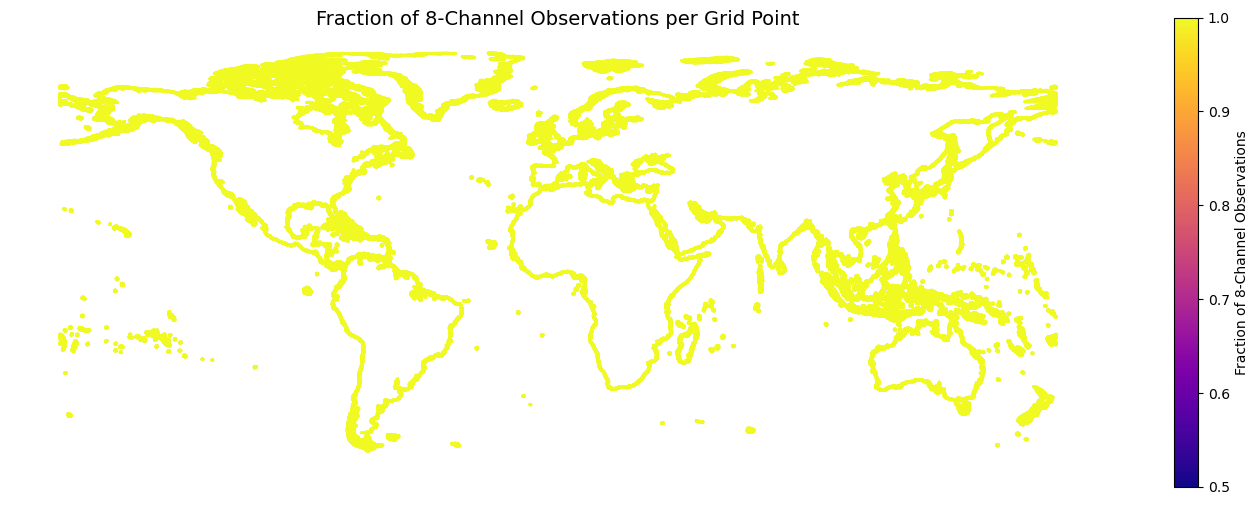

In [27]:
# --- Fraction of has_8_channel per Grid Point ---
df_fraction_8ch_all = con.execute("""
    SELECT grid_idx,
           COUNT(*) AS total,
           SUM(CASE WHEN has_8_channel THEN 1 ELSE 0 END)::DOUBLE / COUNT(*) AS frac_8_channel
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_idx
""").fetchdf()

geo_frac = gdf.join(df_fraction_8ch_all.set_index("grid_idx"), how="inner")

# Set up the figure
fig, ax = plt.subplots(figsize=(14, 7))

# Optional: Plot world basemap
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world.plot(ax=ax, color='lightgray', edgecolor='white')

# Plot points with frac_8_channel shading
geo_frac.plot(
    ax=ax,
    column="frac_8_channel",
    cmap="plasma",
    markersize=1,
    legend=True,
    vmin=0.5,  # Force lower bound
    vmax=1.0,  # Force upper bound
    legend_kwds={
        "label": "Fraction of 8-Channel Observations",
        "shrink": 0.7,
        "orientation": "vertical"
    }
)

ax.set_title("Fraction of 8-Channel Observations per Grid Point", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()